In [1]:
import gym
import numpy as np
import random
import cv2

from collections import deque

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, Flatten
from keras.optimizers import Adam
from keras import backend as K

from matplotlib import pyplot as plt

env = gym.make('Breakout-v0')

Using TensorFlow backend.


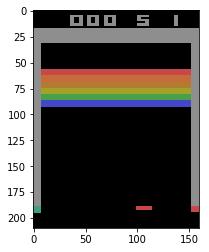

In [2]:
state = env.reset()
for i in range(1000):
    env.render()
    env.step(env.action_space.sample())
    
env.close()
plt.imshow(state, cmap='gray')

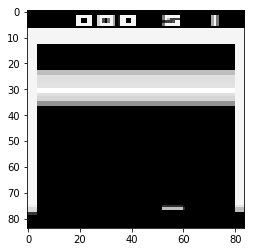

In [ ]:
image = np.copy(state)

def grayscale_image(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def resize_image(img):
    return cv2.resize(img, (84, 84))

def preprocess_image(img):
    return resize_image(grayscale_image(img))

processed = preprocess_image(image)
plt.imshow(processed, cmap='gray')

In [ ]:
class DeepQLearning:
    def __init__(self, state_shape, action_size, memory_length=1000000):
        self.state_shape = state_shape
        self.action_size = action_size
        self.memory = deque(maxlen=memory_length)
        
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99995
        self.learning_rate = 0.001
        
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Conv2D(32, (8, 8), strides=4, input_shape=self.state_shape, activation='relu'))
        model.add(Conv2D(64, (4, 4), strides=2, activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        print(model.summary())
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])
    
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
state_size = env.observation_space.shape[0]
agent = DeepQLearning((84, 84, 4), env.action_space.n)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 20, 32)        8224      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1606144   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 2052      
Total params: 1,686,180
Trainable params: 1,686,180
Non-trainable para

In [ ]:
episodes = 50000
steps = 10000
batch_size = 32

frame_buffer = np.zeros((84, 84, 4)) # 4 frame buffer like in the paper
frame_index = 0
buffer_length = 4

import time

agent.model.load_weights("breakout-v0.h5")

for e in range(episodes):
    state = env.reset()
    score = 0
    last_life_count = 5
    episode_time = time.time()
    for t in range(steps):
        env.render()
        processed = preprocess_image(state)
        frame_buffer[:,:,frame_index] = processed
        action = agent.act(np.expand_dims(frame_buffer, axis=0))
        next_state, reward, done, meta = env.step(action)
        reward = reward if meta['ale.lives'] == last_life_count else -(0.9**last_life_count)
        last_life_count = meta['ale.lives']
        
        next_frame_buffer = np.copy(frame_buffer)
        next_frame_buffer[:, :, (frame_index + 1) % buffer_length] = preprocess_image(next_state)
        agent.remember(np.expand_dims(np.copy(frame_buffer), axis=0), action, reward, np.expand_dims(np.copy(next_frame_buffer), axis=0), done)
        frame_index = (frame_index + 1) % buffer_length
        
        score += reward
        if meta['ale.lives'] <= 0:
            print("episode: {}/{}, score: {}, time: {}, e: {:.2}, t: {:.4}"
                  .format(e, episodes, score, t, agent.epsilon, time.time() - episode_time))
            break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
    agent.model.save_weights("breakout-v0.h5")

env.close()

Instructions for updating:
Use tf.cast instead.
episode: 0/50000, score: -1.6855900000000004, time: 296, e: 0.99, t: 37.67
episode: 1/50000, score: -2.68559, time: 230, e: 0.98, t: 31.17
episode: 2/50000, score: -3.68559, time: 176, e: 0.97, t: 23.66
episode: 3/50000, score: -3.68559, time: 183, e: 0.96, t: 24.93
episode: 4/50000, score: -2.6855900000000004, time: 232, e: 0.95, t: 31.45
episode: 5/50000, score: -2.6855900000000004, time: 224, e: 0.94, t: 30.43
episode: 6/50000, score: 0.31440999999999997, time: 375, e: 0.92, t: 50.76
episode: 7/50000, score: 1.31441, time: 414, e: 0.9, t: 56.44
episode: 8/50000, score: -0.6855900000000003, time: 308, e: 0.89, t: 41.98
episode: 9/50000, score: -2.6855900000000004, time: 240, e: 0.88, t: 31.77
episode: 10/50000, score: -2.6855900000000004, time: 239, e: 0.87, t: 31.47
episode: 11/50000, score: -2.68559, time: 240, e: 0.86, t: 31.61
episode: 12/50000, score: -3.68559, time: 162, e: 0.85, t: 21.38
episode: 13/50000, score: -3.68559, time: 

episode: 113/50000, score: -0.6855900000000003, time: 362, e: 0.23, t: 45.75
episode: 114/50000, score: -3.68559, time: 212, e: 0.23, t: 26.71
episode: 115/50000, score: -1.6855900000000004, time: 315, e: 0.23, t: 39.69
episode: 116/50000, score: -1.6855900000000004, time: 245, e: 0.22, t: 30.83
episode: 117/50000, score: -1.6855900000000004, time: 276, e: 0.22, t: 34.95
episode: 118/50000, score: -3.68559, time: 219, e: 0.22, t: 27.65
episode: 119/50000, score: -3.68559, time: 204, e: 0.22, t: 25.84
episode: 120/50000, score: -0.68559, time: 304, e: 0.21, t: 38.65
episode: 121/50000, score: -3.68559, time: 220, e: 0.21, t: 27.82
episode: 122/50000, score: -1.6855900000000004, time: 292, e: 0.21, t: 36.84
episode: 123/50000, score: -3.68559, time: 215, e: 0.21, t: 27.09
episode: 124/50000, score: -1.6855900000000004, time: 287, e: 0.2, t: 36.28
episode: 125/50000, score: -1.6855900000000001, time: 367, e: 0.2, t: 46.34
episode: 126/50000, score: -1.6855900000000004, time: 277, e: 0.2, 

episode: 225/50000, score: 0.31440999999999997, time: 445, e: 0.045, t: 57.83
episode: 226/50000, score: -0.6855900000000001, time: 341, e: 0.044, t: 44.48
episode: 227/50000, score: -2.6855900000000004, time: 320, e: 0.043, t: 41.48
episode: 228/50000, score: 0.31440999999999997, time: 433, e: 0.042, t: 56.49
episode: 229/50000, score: -2.6855900000000004, time: 268, e: 0.042, t: 34.74
episode: 230/50000, score: -2.6855900000000004, time: 256, e: 0.041, t: 33.22
episode: 231/50000, score: 1.31441, time: 440, e: 0.04, t: 57.2
episode: 232/50000, score: -2.6855900000000004, time: 294, e: 0.04, t: 38.18
episode: 233/50000, score: -2.6855900000000004, time: 322, e: 0.039, t: 41.85
episode: 234/50000, score: -2.6855900000000004, time: 294, e: 0.039, t: 37.25
episode: 235/50000, score: -0.68559, time: 376, e: 0.038, t: 47.59
episode: 236/50000, score: -1.6855900000000004, time: 338, e: 0.037, t: 42.79
episode: 237/50000, score: -1.6855900000000004, time: 320, e: 0.037, t: 40.57
episode: 238

episode: 339/50000, score: -3.68559, time: 178, e: 0.01, t: 22.54
episode: 340/50000, score: -2.6855900000000004, time: 270, e: 0.01, t: 34.2
episode: 341/50000, score: -3.68559, time: 306, e: 0.01, t: 38.78
episode: 342/50000, score: -1.6855900000000004, time: 460, e: 0.01, t: 58.4
episode: 343/50000, score: -2.6855900000000004, time: 555, e: 0.01, t: 70.19
episode: 344/50000, score: -0.68559, time: 331, e: 0.01, t: 42.06
episode: 345/50000, score: -2.6855900000000004, time: 310, e: 0.01, t: 39.24
episode: 346/50000, score: -1.6855900000000004, time: 308, e: 0.01, t: 38.94
episode: 347/50000, score: -2.6855900000000004, time: 346, e: 0.01, t: 44.11
episode: 348/50000, score: -3.68559, time: 406, e: 0.01, t: 51.53
episode: 349/50000, score: -3.68559, time: 182, e: 0.01, t: 23.02
episode: 350/50000, score: -1.6855900000000004, time: 310, e: 0.01, t: 39.43
episode: 351/50000, score: -2.6855900000000004, time: 240, e: 0.01, t: 32.18
episode: 352/50000, score: -2.6855900000000004, time: 34

episode: 453/50000, score: -1.6855900000000004, time: 255, e: 0.01, t: 35.33
episode: 454/50000, score: -0.6855900000000003, time: 400, e: 0.01, t: 55.97
episode: 455/50000, score: -0.68559, time: 308, e: 0.01, t: 43.79
episode: 456/50000, score: -1.6855900000000004, time: 337, e: 0.01, t: 48.57
episode: 457/50000, score: -3.68559, time: 331, e: 0.01, t: 47.68
episode: 458/50000, score: -0.68559, time: 393, e: 0.01, t: 57.24
episode: 459/50000, score: -3.68559, time: 338, e: 0.01, t: 49.82
episode: 460/50000, score: -3.68559, time: 201, e: 0.01, t: 29.62
episode: 461/50000, score: -3.68559, time: 320, e: 0.01, t: 47.95
episode: 462/50000, score: -3.68559, time: 320, e: 0.01, t: 47.99
episode: 463/50000, score: -3.68559, time: 203, e: 0.01, t: 30.67
episode: 464/50000, score: -3.68559, time: 230, e: 0.01, t: 34.72
episode: 465/50000, score: -2.68559, time: 274, e: 0.01, t: 41.2
episode: 466/50000, score: 1.31441, time: 478, e: 0.01, t: 72.61
episode: 467/50000, score: -3.68559, time: 19

In [ ]:
env.close()